# Resnet Implementation on CIFAR-10 dataset using 32x32x3 image dimension

## Import libraries and define global constants

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils import train_valid_model
import time
import json

MODEL_PATH = 'model/cifar10_resnet.pth'
BATCH_SIZE = 4
EPOCHS = 10
DEVICE = (
  "cuda"
  if torch.cuda.is_available()
  else "mps"
  if torch.backends.mps.is_available()
  else "cpu"
)
print(DEVICE)

cuda


## Prepare image transformation and generators 

In [2]:
transform = v2.Compose([
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
trainset = CIFAR10('data', train=True, download=False, transform=transform)
validset = CIFAR10('data', train=False, download=False, transform=transform)

In [4]:
train_dataloader = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(validset, BATCH_SIZE, shuffle=False, num_workers=2)

## Define model, initialize and state the forward pass

In [5]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # MUST maintain the same dimensionality for residual block
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: # Add Maxpooling layer if pool is true
      layers.append(nn.MaxPool2d(2)) # Default stride would be None, but would be replaced with kernel size if prompted
      
    return nn.Sequential(*layers) # unpack arguments defined with layers

In [6]:
class ResNet9(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(ResNet9, self).__init__()

    self.conv1 = conv_block(in_channels, 64) # 32x32x64
    self.conv2 = conv_block(64, 128, pool=True) # 16x16x128
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 16x16x128
    
    self.conv3 = conv_block(128, 256, pool=True) # 8x8x256
    self.conv4 = conv_block(256, 512, pool=True) # 4x4x512
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 4x4x512

    self.linear = nn.Sequential(nn.MaxPool2d(4), # 1x1x512
                                    nn.Flatten(), 
                                    nn.Linear(512, num_classes))
        
  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.res1(x) + x
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.res2(x) + x
      x = self.linear(x)
      return x

# in_channels = 3, num_classes = 10
model = ResNet9(3, 10).to(DEVICE)
print(model)

""" 
  Resnet architecture with CIFAR10 image support by kamal Das
"""

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

' \n  Resnet architecture with CIFAR10 image support by kamal Das\n'

## Run the model on training loop with validation

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [8]:
def main():
  train_loss_history, train_accuracy_history = [], []
  valid_loss_history, valid_accuracy_history = [], []
  tik = time.time()

  for epochs in range(EPOCHS):
    train_loss, train_accuracy = train_valid_model.train(model, train_dataloader, loss_fn, optimizer, DEVICE, log=False)
    valid_loss, valid_accuracy = train_valid_model.valid(model, valid_dataloader, loss_fn, DEVICE, log=False)

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

  print(f"Training/Validation Time Elapsed: {time.time() - tik:>.3f}")
  return train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history

In [9]:
if __name__ == "__main__":
  train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = main()

Loss: 3.344151 [16000/50000]
Loss: 2.057098 [32000/50000]
Loss: 0.592812 [48000/50000]
Validation Error ----- Loss: 0.38040045 Accuracy: 55.47
Loss: 0.495111 [16000/50000]
Loss: 0.627509 [32000/50000]
Loss: 2.559055 [48000/50000]
Validation Error ----- Loss: 0.22400489 Accuracy: 71.27
Loss: 1.214091 [16000/50000]
Loss: 0.227387 [32000/50000]
Loss: 0.445885 [48000/50000]
Validation Error ----- Loss: 0.23332144 Accuracy: 72.83
Loss: 0.636801 [16000/50000]
Loss: 0.013973 [32000/50000]
Loss: 0.748287 [48000/50000]
Validation Error ----- Loss: 0.20776253 Accuracy: 77.39
Loss: 0.015661 [16000/50000]
Loss: 0.117774 [32000/50000]
Loss: 1.622955 [48000/50000]
Validation Error ----- Loss: 0.22549249 Accuracy: 78.56
Loss: 0.054722 [16000/50000]
Loss: 0.567285 [32000/50000]
Loss: 0.098501 [48000/50000]
Validation Error ----- Loss: 0.25800423 Accuracy: 79.13
Loss: 0.161910 [16000/50000]
Loss: 1.259362 [32000/50000]
Loss: 0.010497 [48000/50000]
Validation Error ----- Loss: 0.15793599 Accuracy: 82.70

## Save model and loss/accuracy history with torch and json

In [10]:
torch.save(model.state_dict(), MODEL_PATH)

In [11]:
with open("listHistory/train_l_a_resnet", 'w') as f:
  json.dump([train_loss_history, train_accuracy_history], f)

with open("listHistory/valid_l_a_resnet", 'w') as f:
  json.dump([valid_loss_history, valid_accuracy_history], f)

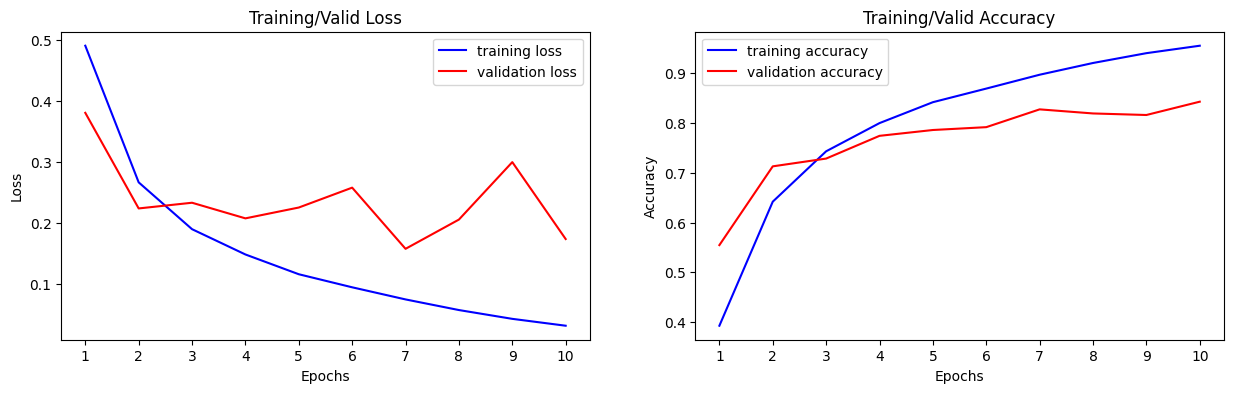

In [12]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax[0].set_title("Training/Valid Loss")
ax[0].plot(train_loss_history, label="training loss", c='blue')
ax[0].plot(valid_loss_history, label="validation loss", c='red')
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_xticks(range(0, EPOCHS), range(1, EPOCHS+1))
ax[0].legend()

ax[1].set_title("Training/Valid Accuracy")
ax[1].plot(train_accuracy_history, label="training accuracy", c='blue')
ax[1].plot(valid_accuracy_history, label="validation accuracy", c='red')
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_xticks(range(0, EPOCHS), range(1, EPOCHS+1))
ax[1].legend()
plt.show()

## Load saved model and json history list

##### Run import libraries and cnn defition (NeuralNetwork()) only

In [13]:
model = ResNet9(3, 10).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [14]:
with open("listHistory/train_l_a_resnet", "r") as f:
  train_history = json.load(f)

with open("listHistory/valid_l_a_resnet", "r") as f:
  valid_history = json.load(f)

In [15]:
train_loss, train_accuracy = train_history[0], train_history[1]
valid_loss, valid_accuracy = valid_history[0], valid_history[1]
print(f"train loss: {train_loss}\ntrain accuracy: {train_accuracy}")
print(f"valid loss: {valid_loss}\nvalid accuracy: {valid_accuracy}")

train loss: [0.4901914248365164, 0.2666798426426202, 0.1900529476737464, 0.14867999972281162, 0.11634188377885832, 0.09497465513371775, 0.07514925640324648, 0.05775906882767533, 0.04336684662999909, 0.03212387648994808]
train accuracy: [0.393, 0.64184, 0.74288, 0.79944, 0.84138, 0.86868, 0.89648, 0.92002, 0.93972, 0.95466]
valid loss: [0.3804004536051303, 0.2240048857237678, 0.23332144063962332, 0.20776252689379618, 0.22549249161232146, 0.2580042266508477, 0.1579359931895876, 0.2057793150787772, 0.29977571927562113, 0.17395956393987239]
valid accuracy: [0.5547, 0.7127, 0.7283, 0.7739, 0.7856, 0.7913, 0.827, 0.8188, 0.8157, 0.8424]
